## Representing uncertainty on Lie groups

We'll quickly take a look at how we can model uncertainty over elements on a matrix Lie group as Gaussian perturbations in the Lie algebra. The resulting distribution in the Lie group is notably non Gaussian.

The left and right invariant error terms are defined
\begin{align}
\eta_\mathtt{right} &= \bar{\mathrm{X}} \mathrm{X}^{-1}
  &= \left(\bar{\mathrm{X}} \mathrm{\Gamma} \right) \left(\bar{\mathrm{X}} \mathrm{\Gamma} \right)^{-1} \\
\eta_\mathtt{left} &= \mathrm{X}^{-1} \bar{\mathrm{X}}
  &= \left(\mathrm{\Gamma} \bar{\mathrm{X}} \right)^{-1} \left(\mathrm{\Gamma} \bar{\mathrm{X}} \right)
\end{align}
where $\mathrm{X}$ and $\bar{\mathrm{X}}$ are the true and estimated states, respectively.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.linalg import block_diag
from scipy.stats import norm

import liegroup

In [2]:
rng = np.random.default_rng(seed=0)

In [3]:
def plot_covariance(ax_se2, ax_SE2, mu, Sigma, *pargs, scale, **pkwargs):
    L = np.linalg.cholesky(Sigma)
    
    t = np.linspace(np.pi, -np.pi, 500)
    circle = np.vstack([np.cos(t), np.sin(t), np.zeros_like(t)]).T
    
    ellipse_se2 = scale * (L @ circle.T).T
    if ax_se2 is not None:
        ax_se2.plot(ellipse_se2[:, 0], ellipse_se2[:, 1], *pargs, **pkwargs)
    
    ellipse_SE2 = np.array([mu @ liegroup.SE2.exp(se2).p for se2 in ellipse_se2])
    if ax_SE2 is not None:
        ax_SE2.plot(ellipse_SE2[:, 0], ellipse_SE2[:, 1], *pargs, **pkwargs)

In [4]:
def plot_distribution(transform_bar, cov, transforms):
    du = np.array([(transform_bar.inverse() @ transform).log() for transform in transforms])
    translation = np.array([transform.p for transform in transforms])
    
    fig = plt.figure(figsize=(12, 4))

    ax1 = fig.add_subplot(121)
    ax1.plot(du[:, 0], du[:, 1], 'o', mfc='k', mec='none', alpha=0.25)
    ax1.axis('equal')
    ax1.grid()
    ax1.set_title('Lie algebra')

    ax2 = fig.add_subplot(122)
    ax2.plot(translation[:, 0], translation[:, 1], 'o', mfc='g', mec='none', alpha=0.25)
    ax2.axis('equal')
    ax2.grid()
    ax2.set_title('Lie group')

    plot_covariance(ax1, ax2, transform_bar, cov, 'r', scale=3, lw=2)

Let's first sample from a distribution
\begin{equation}
\mathrm{X}_\mathtt{L1} = \bar{\mathrm{X}}_\mathtt{L1} \exp \left( \delta u_\times \right) ,
\end{equation}
where $\delta u \sim \mathcal{N}(0, \Sigma)$. In this case, the noise perturbation lives in the tangent space of $\bar{\mathrm{X}}_\mathtt{L1}$.

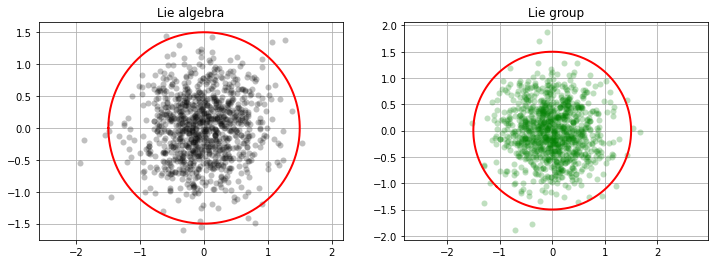

In [5]:
# Sample points in Lie algebra
transform_L1_bar = liegroup.SE2(so2=liegroup.SO2.exp(np.deg2rad(45.0)),
                                p=np.zeros(2))
cov1 = block_diag((0.5)**2 * np.eye(2), [np.deg2rad(25)**2])

# Sample a bunch of perturbations from this distribution.
du1 = (np.linalg.cholesky(cov1) @ rng.normal(size=(3, 1000))).T
transform_L1_list = [transform_L1_bar @ liegroup.SE2.exp(u) for u in du1]

plot_distribution(transform_L1_bar, cov1, transform_L1_list)

Subsequently applying a (nonrandom) transformtation yields
\begin{align}
\mathrm{X}_\mathtt{L2} &= \mathrm{X}_\mathtt{L1} \mathrm{X}_\mathtt{12} \\
&= \bar{\mathrm{X}}_\mathtt{L1} \exp \left( \delta u_\times \right) \mathrm{X}_\mathtt{12} \\
&= \bar{\mathrm{X}}_\mathtt{L1} \mathrm{X}_\mathtt{12}
  \exp \left( \mathrm{Ad}_{\mathrm{X}_\mathtt{12}^{-1}} \delta u_\times \right) \\
&= \bar{\mathrm{X}}_\mathtt{L2} \exp \left( \delta u_\times' \right)
\end{align}
where $\delta u' \sim \mathcal{N}(0, \mathrm{Ad}_{\mathrm{X}_\mathtt{12}^{-1}} \Sigma \mathrm{Ad}_{\mathrm{X}_\mathtt{12}^{-1}}^\top)$.

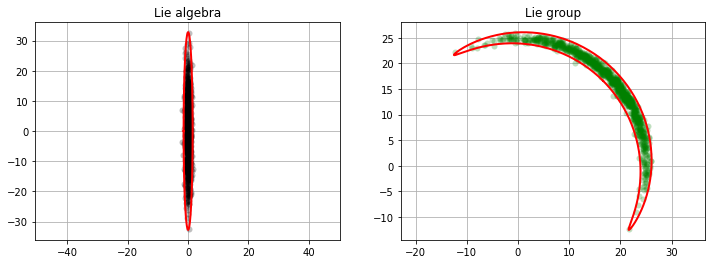

In [6]:
transform_12 = liegroup.SE2(so2=liegroup.SO2.exp(np.deg2rad(0)),
                            p=np.array([25.0, 0.0]))
transform_L2_bar = transform_L1_bar @ transform_12

A = transform_12.inverse().adj()
cov2 = A @ cov1 @ A.T

# Propagate our samples, too.
transform_L2_list = [transform_L1 @ transform_12 for transform_L1 in transform_L1_list]

plot_distribution(transform_L2_bar, cov2, transform_L2_list)

Let's try to condition on some other information and see what happens.

We have some noisy observation, $\mathrm{\mathbf{z}}$, that we can describe in terms our state $\mathrm{X}$. We'll first approximate the joint distribution $p(\mathrm{\mathbf{z}}, \delta u)$ and then condition on the observation to obtain the posterior $p(\delta u | \mathrm{\mathbf{z}})$.

Suppose we have some noisy observation of our position $\mathrm{\mathbf{z}} = \mathrm{\mathbf{p}} + \mathrm{\mathbf{w}}$. We can approximately model this observation with respect to our state perturbation
\begin{align}
\mathrm{\mathbf{z}} &=
  \underbrace{\begin{bmatrix} \mathbf{I}_{2,2} & \mathbf{0}_{2,1} \end{bmatrix}}_{\mathrm{P}}
  \begin{bmatrix} \mathrm{R} & \mathrm{\mathbf{p}} \\ \mathbf{0}_{1,2} & 1 \end{bmatrix}
  \begin{bmatrix} \mathrm{\mathbf{0}}_{2, 1} \\ 1 \end{bmatrix} +
  \mathrm{\mathbf{w}} \\
&= \mathrm{P} \bar{\mathrm{X}} \exp \left( \delta u_\times \right) \mathrm{\mathbf{d}} + \mathrm{\mathbf{w}} \\
&\approx \mathrm{P} \bar{\mathrm{X}} \left(\mathrm{I} + \delta u_\times \right) \mathrm{\mathbf{d}} + \mathrm{\mathbf{w}}
\end{align}

Note that

\begin{align}
\delta u_\times \mathrm{\mathbf{d}} &=
  \begin{bmatrix} \mathbf{I}_{2,2} & \mathbf{0}_{2,1} \\ \mathbf{0}_{1,2} & 0 \end{bmatrix} \delta u
\end{align}

We now define the innovation
\begin{align}
\mathrm{\mathbf{y}} &= \mathrm{\mathbf{z}} - \mathrm{P} \bar{\mathrm{X}} \mathrm{\mathbf{d}} \\
&= \underbrace{\begin{bmatrix} \mathbf{I}_{2,2} & \mathbf{0}_{2,1} \end{bmatrix} \bar{\mathrm{X}}
  \begin{bmatrix} \mathbf{I}_{2,2} & \mathbf{0}_{2,1} \\ \mathbf{0}_{1,2} & 0 \end{bmatrix}}_{\mathrm{H}} \delta u + \mathrm{\mathbf{w}}
\end{align}

Recognizing that the distribution over the linearized innovation is the sum of two independent Gaussian distributions, we know that the joint distribution over the perturbation state and the innovation is Gaussian with parameters
\begin{align}
\mathrm{E}\left[\delta u, \mathrm{\mathbf{y}} \right] &= \mathbf{0} \\
\mathrm{Cov}\left[\delta u, \mathrm{\mathbf{y}} \right] &=
  \begin{bmatrix}
    \mathrm{\Sigma} & \mathrm{\Sigma} \mathrm{H}^\top \\
    \mathrm{H} \mathrm{\Sigma} & \mathrm{H} \mathrm{\Sigma} \mathrm{H}^\top + \mathrm{R}
  \end{bmatrix}
\end{align}

Finally, we can apply the Schur complement trick to obtain the conditional
\begin{align}
\mathrm{E}\left[ \delta u | \mathrm{\mathbf{y}} \right] &=
  \mathrm{\Sigma} \mathrm{H}^\top \left( \mathrm{H} \mathrm{\Sigma} \mathrm{H}^\top + \mathrm{R} \right)^{-1}
  \mathrm{\mathbf{y}} \\
\mathrm{Cov}\left[ \delta u | \mathrm{\mathbf{y}} \right] &= \mathrm{\Sigma} -
  \mathrm{\Sigma} \mathrm{H}^\top \left( \mathrm{H} \mathrm{\Sigma} \mathrm{H}^\top + \mathrm{R} \right)^{-1}
  \mathrm{H} \mathrm{\Sigma}
\end{align}

This produces the familiar Kalman update...

What's resetting our perturbation state like? Do we need to update the covariance?

In [10]:
def plot_univariate(ax, mean, std, *args, **kwargs):
    t = np.linspace(norm.ppf(0.01, loc=mean, scale=3 * std),
                    norm.ppf(0.99, loc=mean, scale=3 * std), 100)
    ax.plot(t, norm.pdf(t, loc=mean, scale=std), *args, **kwargs)

In [11]:
z = np.array([5, 24.5])
R = (3.0 ** 2) * np.eye(2)

P = np.array([[1, 0, 0], [0, 1, 0]])
d = np.array([0, 0, 1])
y = z - P @ transform_L2_bar.matrix() @ d

D = np.array([[1, 0, 0], [0, 1, 0], [0, 0, 0]])
H = P @ transform_L2_bar.matrix() @ D

S = H @ cov2 @ H.T + R
Sinv = np.linalg.inv(S)
K = cov2 @ H.T @ Sinv

du_plus = K @ y
transform_L2_bar_plus = transform_L2_bar @ liegroup.SE2.exp(du_plus)
cov2_plus = (np.eye(3) - K @ H) @ cov2

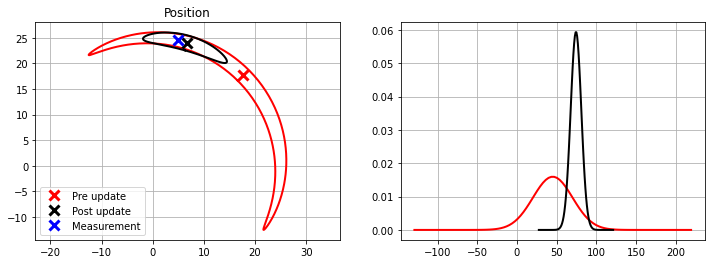

In [12]:
fig = plt.figure(figsize=(12, 4))
ax1 = fig.add_subplot(121)

plot_covariance(None, ax1, transform_L2_bar, cov2, 'r', scale=3, lw=2)
ax1.plot(transform_L2_bar.p[0], transform_L2_bar.p[1], 'x', mec='r', ms=10, mew=3, label='Pre update')

plot_covariance(None, ax1, transform_L2_bar_plus, cov2_plus, 'k', scale=3, lw=2)
ax1.plot(transform_L2_bar_plus.p[0], transform_L2_bar_plus.p[1], 'x', mec='k', ms=10, mew=3, label='Post update')

ax1.plot(z[0], z[1], 'x', mec='b', ms=10, mew=3, label='Measurement')

ax1.axis('equal')
ax1.grid()
ax1.legend()
ax1.set_title('Position')

ax2 = fig.add_subplot(122)

plot_univariate(ax2, np.rad2deg(transform_L2_bar.so2.log()),
                np.rad2deg(np.sqrt(cov2[2, 2])), 'r', lw=2)

plot_univariate(ax2, np.rad2deg(transform_L2_bar_plus.so2.log()),
                np.rad2deg(np.sqrt(cov2_plus[2, 2])), 'k', lw=2)

ax2.grid()

XXX show cost surface and MAP state... (maybe XY cost surface per theta slice)

In [13]:
import pandas as pd

In [56]:
class Simulator:
    def __init__(self):
        self.transform_LV = liegroup.SE2(so2=liegroup.SO2.exp(np.deg2rad(45.0)),
                                         p=np.zeros(2))
        
        self.transform_V1V2 = liegroup.SE2(so2=liegroup.SO2.exp(np.deg2rad(0.5)),
                                           p=np.array([0.25, 0.0]))
        self.L_odo = np.linalg.cholesky(block_diag((0.01)**2 * np.eye(2), [np.deg2rad(0.5)**2]))
        self.L_obs = np.linalg.cholesky(3.0**2 * np.eye(2))
        
        self.archive = []
    
    def run_steps(self, *, num_steps):
        for i in range(num_steps):
            # Archive state.
            transform_V1V2 = self.transform_V1V2 @ liegroup.SE2.exp(self.L_odo @ rng.normal(size=(3,)))
            z_translation_LV1 = self.transform_LV.p + self.L_obs @ rng.normal(size=(2,))
            self.archive.append({'transform_LV1': self.transform_LV.p.tolist() + [self.transform_LV.so2.log()],
                                 'z_translation_LV1': z_translation_LV1.tolist(),
                                 'transform_V1V2':
                                     self.transform_V1V2.p.tolist() + [self.transform_V1V2.so2.log()]})
            
            # Propagate odometry to next state.
            self.transform_LV = self.transform_LV @ transform_V1V2
            
    def to_dataframe(self):
        transforms = np.array([a['transform_LV1'] for a in self.archive])
        observations = np.array([a['z_translation_LV1'] for a in self.archive])
        odometry = np.array([a['transform_V1V2'] for a in self.archive])
        return pd.DataFrame(data=np.hstack([transforms, observations, odometry]),
                            columns=['p_LV_Lx', 'p_LV_Ly', 'r_LV',
                                     'z_p_LV_Lx', 'z_p_LV_Ly',
                                     'p_V1V2_V1x', 'p_V1V2_V1y', 'r_V1V2'])

In [57]:
sim = Simulator()
sim.run_steps(num_steps=250)
df = sim.to_dataframe()

(-15.561474042481212,
 18.38924613792063,
 -4.3184553276183735,
 55.209574617500685)

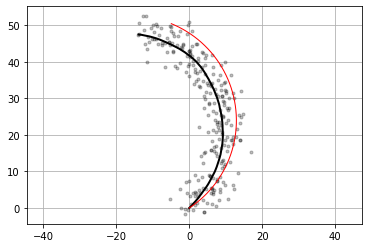

In [60]:
transform_LV = liegroup.SE2(so2=liegroup.SO2.exp(df['r_LV'][0] - 0.2),
                            p=[df['p_LV_Lx'][0], df['p_LV_Ly'][0]])
odo = []
for row in df.itertuples():
    transform_V1V2 = liegroup.SE2(so2=liegroup.SO2.exp(row.r_V1V2),
                                  p=[row.p_V1V2_V1x, row.p_V1V2_V1y])
    odo.append(transform_LV.p[:])
    transform_LV = transform_LV @ transform_V1V2
odo = np.array(odo)

fig = plt.figure()
ax = fig.add_subplot(111)

ax.plot(df['p_LV_Lx'], df['p_LV_Ly'], 'k-', lw=2)
ax.plot(df['z_p_LV_Lx'], df['z_p_LV_Ly'], 'k.', alpha=0.25)
ax.plot(odo[:, 0], odo[:, 1], 'r-', lw=1)

ax.grid()
ax.axis('equal')